# EuroSAT activity

This week we will develop a convolutional network to classify land use and land cover (LULC) in the EuroSAT dataset (Helber et al., 2019). The dataset contains of 27,000 labeled Sentinel-2 images over Europe with ten different land use and land cover classes. The paper can be accessed [here](https://ieeexplore.ieee.org/document/8736785) and the dataset can be accessed [here](https://zenodo.org/records/7711810). We will just be using the RGB version so download the `EuroSAT_RGB.zip` file.

We should start by activating our `TensorFlow` environment:

```
conda activate tf
```

Open a Jupyter Notebook by running:

```
jupyter notebook
```

## Import packages

In [1]:
# Import packages
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import PIL
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, preprocessing, models
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

## Explore dataset

We will start by exploring the dataset by loading one image. 

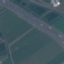

In [2]:
# Open one image file
image = PIL.Image.open('data/EuroSAT_RGB/Highway/Highway_5.jpg')
image

In [3]:
# Print dimensions
print(image.height, image.width)

64 64


In [4]:
# Print min-max values in each band
print(image.getextrema())

((40, 231), (65, 222), (79, 217))


It looks like our data are 8-bit (i.e. have values between 0-255). For machine learning, a common practice is to normalize the values to a range between 0 and 1 which we can do by setting rescale to `1/255`.

In [5]:
# Normalize
rescale = 1.0/255

Now we define some other variables. Note that `validation_split` is the proportion of images that will be held out for testing purposes while the model is training. 

In [6]:
dataset_url = 'data/EuroSAT_RGB/'
batch_size = 32
validation_split = 0.2

TensorFlow has some useful functions for generating training and testing datasets directly from our data directory. The directory structure has to be:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

In [7]:
datagen = preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = preprocessing.image_dataset_from_directory(dataset_url, image_size=(image.height, image.width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


Once we have these, we can print the class names by running

In [8]:
dataset.class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

2025-10-06 09:20:17.146214: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


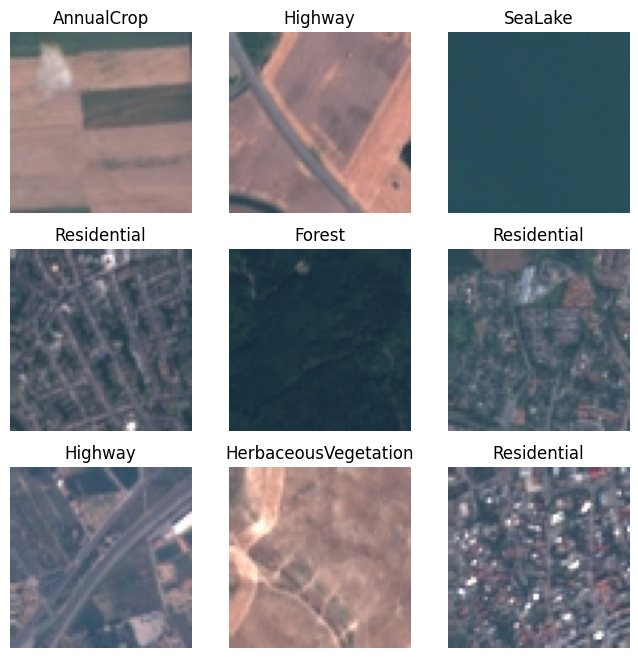

In [9]:
class_names = dataset.class_names
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Split into training and testing datasets

In [10]:
# Define training dataset
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(image.height, image.width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


````{margin}
```{note}
Setting `class_mode` to `categorical` converts the training labels into [2D one-hot encoded labels](https://en.wikipedia.org/wiki/One-hot).
```
````

In [11]:
# Define testing dataset
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(image.height, image.width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


## Build and train model

```{note}
May take a few minutes
```

In [12]:
# Define CNN
model = models.Sequential([
    layers.Input(shape=(image.height, image.width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10, batch_size=32)

Epoch 1/10


/opt/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.4323 - loss: 1.4832 - val_accuracy: 0.6726 - val_loss: 0.9060
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6987 - loss: 0.8384 - val_accuracy: 0.7537 - val_loss: 0.6880
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.7636 - loss: 0.6447 - val_accuracy: 0.7709 - val_loss: 0.6390
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8068 - loss: 0.5400 - val_accuracy: 0.7754 - val_loss: 0.6275
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8247 - loss: 0.4850 - val_accuracy: 0.7887 - val_loss: 0.5870
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8591 - loss: 0.3913 - val_accuracy: 0.7872 - val_loss: 0.6082
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8755 - loss: 0.3487 - val_accuracy: 0.8233 - val_loss: 0.5091
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9004 - loss: 0.2887 - val_accurac

```{note}
Better accuracy could be acheived with a larger model tha is trained for longer. Helber et al. (2021) for example trained a ResNet-50 model for 120 epochs (see [Table III](https://ieeexplore.ieee.org/document/8736785)) and achieved an overall accuracy of 98.6%.
```

In [13]:
# Save model
model.save('model/u-net-10-epochs.keras')

## Load model

In [14]:
model = models.load_model('model/u-net-10-epochs.keras')

## Confusion matrix

In [15]:
y_pred = []
y_true = []

# Iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):
    
    # Append true labels
    y_true.append(label_batch)
    
    # Compute predictions
    preds = model.predict(image_batch, verbose=0)
    
    # Append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# Convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# Define confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)

## Plot confusion matrix

Text(0.5, -61.902777777777814, 'Predicted label')

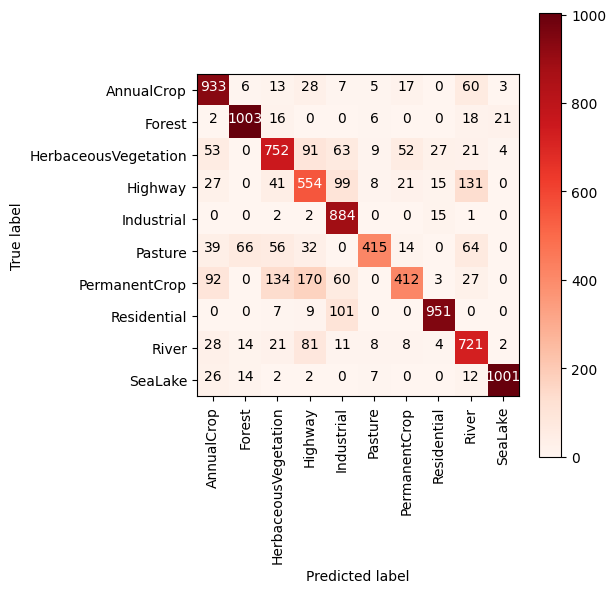

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.class_indices))
plt.xticks(tick_marks, train_dataset.class_indices, rotation=90)
plt.yticks(tick_marks, train_dataset.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

```{important}
Please submit your notebook in `.pdf` format to Canvas by the deadline as evidence of your work.
```

## References

Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). [EuroSAT: A novel dataset and deep learning benchmark for land use and land cover classification](https://ieeexplore.ieee.org/document/8736785). IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.

Kshetri, T. (2024). [Deep Learning Application for Earth Observation](https://github.com/iamtekson/deep-learning-for-earth-observation/blob/main/Notebooks/01.%20image-classification/lulc_classification_euroSAT.ipynb).